# Classificació d'imatges amb CNN

En aquest notebook, es mostra com classificar imatges amb una xarxa neuronal convolucional (CNN). Veurem també quin seria el rendiment d'una xarxa neuronal feedforward (FNN) en aquest mateix problema.

## Instal·lació de l'entorn

En primer lloc, instal·lem les llibreries necessàries per a executar el codi. En el nostre cas, necessitarem `keras`.

In [28]:
%pip install --upgrade torch datasets scikit-learn transformers matplotlib skorch


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Ara importarem les llibreries necessàries per a fer classificació d'imatges utilitzant xarxes neuronals feed forward.

In [29]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import datasets

from PIL import Image

Utilitzarem pytorch per a construir la xarxa neuronal i per a carregar el conjunt de dades.

## Preparem les dades

Com ja sabem, el rendiment de les xarxes neuronals _Feed Forward_ (FNN) en tasques de classificació d'imatges no és gaire bo. Això és degut a que les xarxes FNN no són capaces de capturar les relacions espacials entre els píxels de la imatge. Així i tot, començarem amb una xarxa FNN per a veure quin és el rendiment que podem obtenir.

Com a _DataSet_, utilitzarem el conjunt de dades `cats_vs_dogs` que obtindrem a continuació. Aquest conjunt de dades conté 25.000 imatges en color de 224x224 píxels, amb 2 classes diferents: 'Cat' i 'Dog'.

Son petites, però suficients per a mostrar com funcionen les xarxes neuronals en tasques de classificació d'imatges.

Utilitzarem `datasets` per a carregar el conjunt de dades i `DataLoader` per a carregar les dades en lots.

In [30]:
dataset = datasets.load_dataset('microsoft/cats_vs_dogs')

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

In [31]:
ds_train = dataset['train']
ds_train

Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})

Vejam que les classes s'ha aplicat i algunes de les imatges.

In [32]:
print(dataset['train'][0])

print(dataset['train'].features)

classes = dataset['train'].features["labels"].names
classes

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7FDC1D81C290>, 'labels': 0}
{'image': Image(mode=None, decode=True, id=None), 'labels': ClassLabel(names=['cat', 'dog'], id=None)}


['cat', 'dog']

Les imatges tenen diferents dimensions, però les xarxes neuronals necessiten que totes les imatges tinguin les mateixes dimensions. Per això, redimensionarem les imatges a 128x128 píxels. Utilitzarem el métode `map` de `datasets` per a aplicar la funció de redimensionament a totes les imatges.

In [33]:
def resize_with_padding(image, target_size):
    width, height = image.size
    target_width, target_height = target_size

    if width > height:
        new_width = target_width
        new_height = int(height * target_width / width)
    else:
        new_height = target_height
        new_width = int(width * target_height / height)

    resized = image.resize((new_width, new_height))

    padded = Image.new("RGB", target_size)
    padded.paste(resized, ((target_width - new_width) // 2, (target_height - new_height) // 2))

    return padded

def resize(image, target_size):
    return image.resize(target_size)

def process(x):
    return {"image": resize(x["image"], (128, 128)), "labels": x["labels"]}

ds_train_with_resized_images = ds_train.map(process)

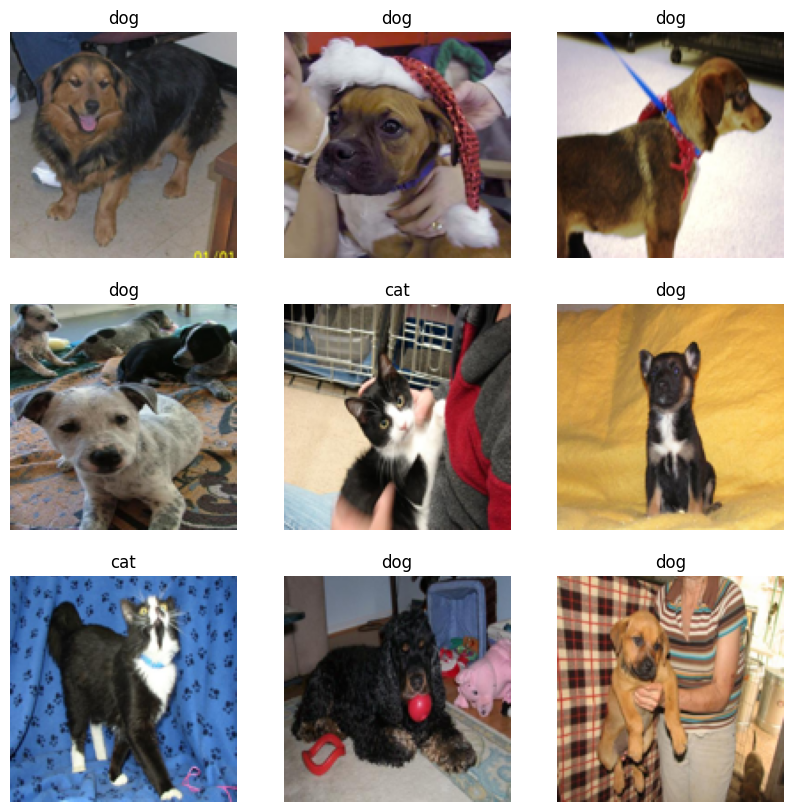

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Mostrem 3x3 imatges de gats i gossos
# Les imatges estan en format PIL

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    random_index = np.random.randint(0, len(ds_train))
    # mostrem el tamany de la imatge
    image = ds_train_with_resized_images[random_index]['image']
    label = ds_train_with_resized_images[random_index]['labels']
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(classes[label])

plt.show()

## Xarxes neuronals feed forward

### Creem el model

Ara crearem el model de xarxa neuronal. Començarem amb una xarxa feed forward. Aquesta xarxa tindrà una capa d'entrada, dues capes ocultes i una capa de sortida.

La capa d'entrada tindrà 128x128x3 = 49152 neurones, ja que les imatges redimensionades tenen 128x128 píxels i 3 canals (RGB).

Per triar les dimensions de les capes ocultes, hem de tenir en compte que les imatges són petites i que volem que el model sigui lleuger. Així i tot, volem que el model sigui prou gran com per a capturar les relacions espacials entre els píxels de les imatges. Per això, triarem dues capes ocultes amb 1024 i 512 neurones, respectivament.

La capa de sortida tindrà 2 neurones, ja que hi ha 2 classes diferents. Utilitzarem la funció d'activació `softmax` per a obtenir les probabilitats de pertànyer a cada classe.

In [42]:
# Creem un DataLoader per carregar les imatges

from torch.utils.data import DataLoader

# La funció collate_fn ens permet processar les dades abans de passar-les a la xarxa
# En aquest cas, convertim les imatges a tensors i les etiquetes a tensors de PyTorch
def collate_fn(batch):
    images = [torch.tensor(np.array(x['image'])) for x in batch]
    labels = [x['labels'] for x in batch]

    tensor_images = torch.stack(images)
    tensor_labels = torch.tensor(labels)

    return tensor_images, tensor_labels

train_loader = DataLoader(ds_train_with_resized_images, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [43]:
model = nn.Sequential( # Sequential ens permet definir una xarxa neuronal com una sequencia de capes
    # Rescalem les dades d'entrada a l'interval [0, 1]. Aixó facilita l'entrenament de la xarxa
    # Transformem les dades d'entrada a un vector unidimensional
    nn.Flatten(),
    # Capa oculta amb 1024 neurones i funció d'activació relu.
    nn.Linear(128 * 128 * 3, 1024),
    nn.ReLU(),
    # Capa oculta amb 512 neurones i funció d'activació relu.
    nn.Linear(1024, 512),
    nn.ReLU(),
    # Capa de sortida amb 1 neurona i funció d'activació sigmoide.
    nn.Linear(512, 1),
    nn.Sigmoid()
)


Ara entrenarem el model. Per a fer-ho, primer hem de compilar-lo. Utilitzarem l'optimitzador `adam` i la funció de pèrdua `binary_crossentropy`. A més, monitoritzarem l'exactitud del model durant l'entrenament.

Un cop compilat el model, l'entrenarem durant 10 èpoques. Utilitzarem un lot de 128 imatges (batch size).

In [44]:
# Volem utilitzar la GPU si està disponible

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Movem el model a la GPU. 
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=49152, out_features=1024, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=1, bias=True)
  (6): Sigmoid()
)

In [45]:
# Definim la funció de pèrdua i l'optimitzador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenem la xarxa neuronal
num_epochs = 5

history = {
    'loss': [],
    'accuracy': []
}

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(torch.float32).to(device)
        labels = labels.to(device).float()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        accuracy = ((outputs > 0.5) == labels.unsqueeze(1)).float().mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history['loss'].append(loss.item())
        history['accuracy'].append(accuracy.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
            print(f'Accuracy: {accuracy.item()}')
        
print('Finished Training')

RuntimeError: stack expects each tensor to be equal size, but got [128, 128, 3] at entry 0 and [128, 128] at entry 29

In [13]:

# Mostrem la pèrdua i l'accuracy durant l'entrenament

plt.plot(history['loss'], label='loss')
plt.plot(history['accuracy'], label='accuracy')
plt.legend()
plt.show()

# Mostrem les prediccions de la xarxa neuronal

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    random_index = np.random.randint(0, len(ds_train))
    image = ds_train_with_resized_images[random_index]['image']
    label = ds_train_with_resized_images[random_index]['labels']
    image_tensor = torch.tensor(np.array(image)).unsqueeze(0).to(device)
    prediction = model(image_tensor).item()
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Prediction: {prediction:.2f}, True: {classes[label]}')

plt.show()

NameError: name 'history' is not defined

In [125]:
def train_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    losses = []
    for batch in data_loader:
        optimizer.zero_grad()
        inputs, labels = batch
        outputs = model(inputs.to(torch.float32))
        loss = loss_fn(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # cada 100 iteracions mostrem la pèrdua i la precisió
        if len(losses) % 10 == 0:
            print(f"Loss: {np.mean(losses)}")
            print(f"Accuracy: {np.mean(outputs.round().detach().cpu().numpy() == labels.cpu().numpy())}")

            
    return losses


def evaluate_model(model, data_loader, loss_fn):
    model.eval()
    losses = []
    for batch in data_loader:
        inputs, labels = batch
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.float().unsqueeze(1))
        losses.append(loss.item())
    return losses


def train(model, train_loader, val_loader, loss_fn, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
        val_loss = evaluate_model(model, val_loader, loss_fn)
        train_losses.extend(train_loss)
        val_losses.extend(val_loss)
        print(
            f"Epoch {epoch} train loss: {np.mean(train_loss)} val loss: {np.mean(val_loss)}"
        )
    return train_losses, val_losses


loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = train(
    model, train_loader, train_loader, loss_fn, optimizer, num_epochs=1
)

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

# Mostrem les imatges amb les seves prediccions

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

Loss: 47.266269135475156
Accuracy: 0.375
Loss: 49.25813456773758
Accuracy: 0.59375
Loss: 50.85958971182505
Accuracy: 0.34375
Loss: 50.72281728386879
Accuracy: 0.53125
Loss: 50.51575382709503
Accuracy: 0.46875


KeyboardInterrupt: 

Com podem veure, no hem aconsseguit gran cosa, ja que el `val_accuracy` apenes passa del 50% (tenient dues classes és equivalent al que tindriem triant a cegues).

Graficarem les dades de l'entrenament per veure-ho més clar.

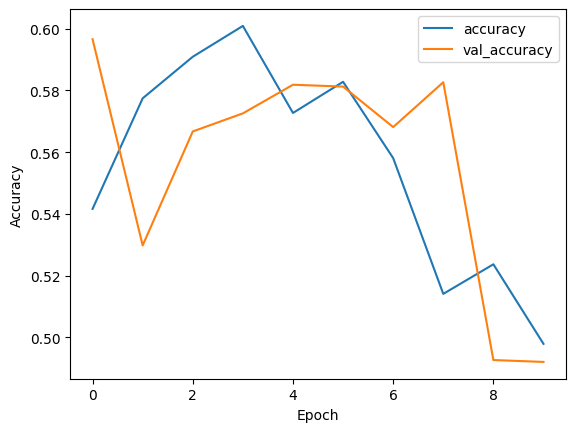

In [10]:
# Mostrem la pèrdua i l'accuracy del model durant l'entrenament.

def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()

plot_history(history)

Podem veure com, en cap moment hem pogut començar a millorar en les nostres prediccions.

Les xarxes neuronals feed forward no són capaces de capturar les relacions espacials entre els píxels de les imatges. Això fa que siguin molt fàcils de sobreajustar, com hem vist. HAurem de provar amb una xarxa neuronal convolucional (CNN) per a veure si podem millorar el rendiment.

## Xarxes neuronals convolucionals (CNN)

De cara a la pràctica, la diferència més gran en la construcció de la xarxa neuronal és que afegirem capes convolucionals i de _pooling_.

Les capes convolucionals són capaces de capturar les relacions espacials entre els píxels de la imatge. Això és el que fa que les CNN siguin molt més eficients que les FNN en tasques de classificació d'imatges.

Les capes de _pooling_ són capaces de reduir la mida de les imatges, mantenint-ne les característiques més importants. Això baixa el nombre de paràmetres de la xarxa i fa que sigui més lleugera.

A més, afegirem capes de _dropout_ per a reduir l'overfitting.

### Creem el model

Ara crearem el model de xarxa neuronal convolucional. Aquesta xarxa tindrà una capa d'entrada, una capa convolucional, una capa densa i una capa de sortida.

A continuació l'entrenarem i veurem com es comporta.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 9)       684       
                                                                 
 flatten_1 (Flatten)         (None, 435600)            0         
                                                                 
 dense_3 (Dense)             (None, 1)                 435601    
                                                                 
Total params: 436285 (1.66 MB)
Trainable params: 436285 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
310/310 [==============================] - 44s 130ms/step - loss: 0.9462 - accuracy: 0.5729 - val_loss: 0.6610 - val_accuracy: 0.6416
Epoch

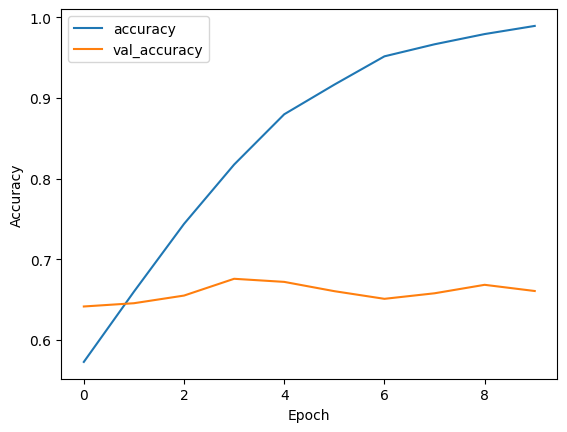

In [11]:
model = Sequential(
    [
        Rescaling(1./255, input_shape=(224, 224, 3)),
        Conv2D(filters=9, kernel_size=(5,5), activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

Podem veure com solament amb una capa convolucional i una capa densa el resultat ja es prou millor que amb la xarxa feed forward. Es obvi com ja es comencen a identificar patrons que identifiquen a gossos i gats, encara que en trobat amb _overfitting_: a partir de la tercera época el `loss` baixa de forma decidida pero el `val_loss` comença a pujar. Per altra banda l'`accuracy` puja i el `val_accuracy` es queda estancat.

Això és degut a que la xarxa és molt petita. Haurem d'apilar més capes convolucionals i de _pooling_ per a millorar el rendiment.

La primera capa convolucional capta patrons bàsics com línies i corbes. Si agreguem més capes convolucionals, aquestes podran capturar patrons més complexos com formes `bàsiques` i, finalment, l'objecte que volem classificar. També augmentarem el nombre de `filters` conforme anem afegint capes convolucionals, ja que conforme els patrons es compliquen hi haurà més possible combinacions de característiques interessants que caldrà capturar.

Per facilitar aquest procés, utilitzarem una tècnica molt útil: reduir el tamany espacial de les imatges. Si hem detectat que en una finestra de `3x3` hi ha una característica important, no ens importa si aquesta característica està en la part superior o inferior de la imatge. Així que podem reduir la mida de la imatge a la meitat. Això és el que fa la capa de _pooling_.

Hi ha dos tipus de _pooling_: _max pooling_ i _average pooling_. El _max pooling_ agafa el valor màxim de la finestra i l'_average pooling_ en fa la mitjana. En general, el _max pooling_ funciona millor que l'_average pooling_.

L'estructura bàsica serà la de capa convolucional, capa de _pooling_ i capa de _dropout_. La capa de _dropout_ és molt útil per a reduir l'overfitting.

Vejam com es comporta la xarxa amb aquesta nova estructura.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 10)      760       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 10)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 10)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 20)      5020      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 20)        0         
 g2D)                                                 

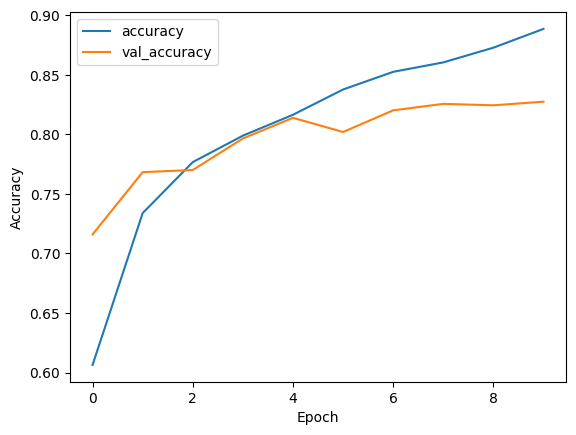

In [12]:
model = Sequential(
    [
        Rescaling(1./255, input_shape=(224, 224, 3)),
        Conv2D(filters=10, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=20, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=40, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

Com podem veure, el rendiment de la xarxa ha millorat prou. Encara hi ha molt marge de millora, ara, però, no tenim un overfitting destacable i seria possible seguir afegint capes convolucionals i de _pooling_ per a millorar el rendiment.

De tota manera anem a veure una altra técnica: _data augmentation_ aplicarem una série de filtres a les imatges (escalats i rotacions) per dversificar les dades d'entrada i, per tant ajudar a la xarxa a generalitzar-se.

Ho podeu executar per veure el resultat. Es possible, però, que necessite més de 10 époques per convergir.

In [ ]:
from keras_cv.layers import RandAugment

model = Sequential(
    [
        Rescaling(1./255, input_shape=(224, 224, 3)),
        RandAugment(value_range=(0, 255), augmentations_per_image=1, magnitude=0.5),
        Conv2D(filters=10, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=20, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=40, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

## Xarxes neuronals convolucionals (CNN) pre-entrenades

Com haurem vist, entrenar una xarxa neuronal convolucional des de zero és una tasca molt costosa. Això és degut a que les xarxes neuronals convolucionals tenen molts paràmetres i entrenar-les requereix moltes dades i temps.

Afortunadament, podem utilitzar xarxes neuronals convolucionals pre-entrenades. Això ens estalvia molt temps i recursos.

Veurem com afinar una xarxa neuronal convolucional pre-entrenada per a que classifique les nostres dades.



Com a exemple, utilitzarem la xarxa `VGG16` pre-entrenada. La xarxa `VGG16` és una xarxa neuronal convolucional molt coneguda i ha estat entrenada amb el conjunt de dades `ImageNet`, que conté més de 14 milions d'imatges i 1000 classes diferents. Està formada per 16 capes, d'aquí el nom. La xarxa `VGG16` és molt potent i ha demostrat ser molt eficient en tasques de classificació d'imatges.

In [ ]:
from keras.applications import VGG16

model = Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)),
    VGG16(include_top=False),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.layers[1].trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               3211392   
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 17927370 (68.39 MB)
Trainable params: 3212682 (12.26 MB)
Non-trainable params: 14714688 (56.13 MB)
________

El resultat ara és molt millor. Això és degut a que hem pogut utilitzar les característiques apreses per la xarxa pre-entrenada per a classificar les imatges.

El _transfer learning_ és molt útil quan no tenim moltes dades o quan no tenim molts recursos per a entrenar una xarxa neuronal convolucional des de zero.

## Utilització en OpenCV

Per a utilitzar la xarxa neuronal convolucional pre-entrenada en OpenCV hauriem de convertir la xarxa a un format que OpenCV pugui llegir. Això és una mica complicat, però es pot fer. De tota manera en aquesta secció veurem com cridar al model de Keras des de OpenCV.

In [51]:
# En opencv carreguem una imatge, la classifiquem i la mostrem.

import cv2

def classify_image_opencv(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) # Carreguem la imatge amb opencv i la convertim a RGB

    img_class = img # Creem una còpia de la imatge per modificar-la
    img_class = cv2.resize(img_class, (224, 224)) # Redimensionem la imatge a 224x224
    img_class = np.expand_dims(img_class, axis=0) # Redimensionem la imatge afegint una dimensió extra per indicar el batch

    pred = model.predict(img_class) # Classifiquem la imatge amb el model

    # Modifiquem la imatge original per agregar la etiqueta en verd
    if pred[0][0] > 0.5:
        print("Cat")
        cv2.putText(img, "Cat", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        print("Dog")
        cv2.putText(img, "Dog", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    plt.imshow(img)

1/1 [==============================] - 0s 19ms/step
Cat


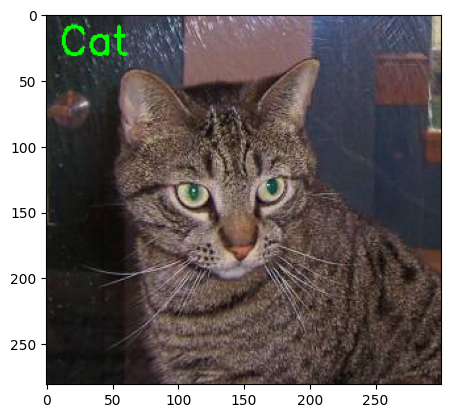

In [52]:
classify_image_opencv('data/PetImages/Cat/1.jpg')

1/1 [==============================] - 0s 20ms/step
Dog


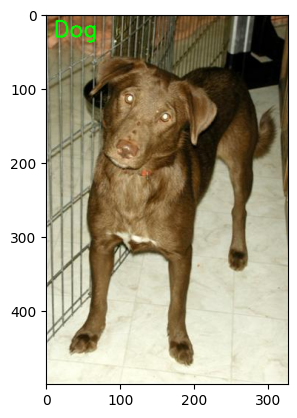

In [53]:
classify_image_opencv('data/PetImages/Dog/1.jpg')